# Trabalho final de LUI

### Davi Oliveira Francisco 
### 231101072

# Descrição do trabalho

### Trabalho da disciplina de **LUI**
##
#### O objetivo do trabalho é extrair informações de uma fonte de sua própria escolha, sendo através de uma **API** ou por **Web Scraping**.
##
#### Você deve fornecer o código com o output do dataframe e as saidas após as seguintes operações de Ordenação e Filtragem.
##
#### Etapas:

1.   Escolher uma API ou site que contenham as informações desejadas
    *   Filmes (API - https://www.omdbapi.com/) ou (Scraping - https://www.imdb.com/chart/toptv/?ref_=nv_tvv_250)
    *   Alimentos (API - https://developer.nutritionix.com/docs/v1_1) ou (Scraping - https://www.nutritionix.com/database/common-foods)
    *   Tempo (API - https://openweathermap.org/api)
    *   Commodities (Scraping - https://www.indexmundi.com/commodities/?commodity=agricultural-raw-materials-price-index&months=360)
    *   Finanças (
Se você desejar também pode pesquisar sua própria API nesse site (https://the-api-collective.com/).

Acima estão listadas apenas sugestões, fiquem à vontade! Inclusive podem utilizar alguma apresentada em aula!

2.   Guardar todas essas informações extraídas em um DataFrame
3.   Executar a operação de ordenação em um atributo escolhido (ao seu critério, podendo ser em ordem numérica ou alfabética)
4.   Executar a operação de filtragem em um atributo escolhido (ao seu critério)


O trabalho pode conter até 5~6 pessoas por grupo, não mais do que isso!

# Scrapping + API

A ideia desenvolvida nesse trabalho envolve a utilização do selenium, para colher informações do site do IMDB top 250 filmes, e analisando o código HTML, com o bs4, podemos alimentar a OMDb API e pegar mais informações dos filmes. Dessa forma, utilizamos os dois métodos sugeridos pelo trabalho.

# Instalando pacotes e importando bibliotecas necessárias

In [25]:
import requests
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import pandas as pd
import time
import re
from tqdm import tqdm
import matplotlib.pyplot as plt

# Buscando os nomes dos top 250 filmes de acordo com o IMDB

## Inicializando o driver do Selenium e realizando request para interagir com a página

In [2]:
# Configurar o driver do navegador (neste exemplo, Chrome)
service = Service('chromedriver-win64\chromedriver.exe')  # Substitua pelo caminho correto do chromedriver
driver = webdriver.Chrome(service=service)

# Acessar a página dos top 250 filmes do IMDb
driver.get("https://www.imdb.com/chart/top/?ref_=nv_mv_250")

# Aguardar o carregamento inicial da página
time.sleep(3)

<>:2: SyntaxWarning: invalid escape sequence '\c'
<>:2: SyntaxWarning: invalid escape sequence '\c'
C:\Users\dofra\AppData\Local\Temp\ipykernel_7144\678114505.py:2: SyntaxWarning: invalid escape sequence '\c'
  service = Service('chromedriver-win64\chromedriver.exe')  # Substitua pelo caminho correto do chromedriver


In [3]:
# Simular a rolagem até o final da página para garantir que todos os filmes sejam carregados (em caso de carregamento dinâmico)
last_height = driver.execute_script("return document.body.scrollHeight")
while True:
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(2)  # Aguardar um tempo para que o conteúdo seja carregado
    new_height = driver.execute_script("return document.body.scrollHeight")
    if new_height == last_height:
        break
    last_height = new_height

# Após rolar a página inteira, pegamos o conteúdo HTML
page_source = driver.page_source

# Analisar o conteúdo com BeautifulSoup
soup = BeautifulSoup(page_source, 'html.parser')

# Fechar o navegador
driver.quit()

## Buscando todos os elementos 'h3' da classe "ipc-title__text"

In [4]:
filmes = soup.find_all('h3', class_='ipc-title__text')

for filme in filmes:
    print(filme.get_text(strip=True))

Tabelas do IMDb
1. Um Sonho de Liberdade
2. O Poderoso Chefão
3. Batman: O Cavaleiro das Trevas
4. O Poderoso Chefão II
5. 12 Homens e uma Sentença
6. A Lista de Schindler
7. O Senhor dos Anéis: O Retorno do Rei
8. Pulp Fiction: Tempo de Violência
9. O Senhor dos Anéis: A Sociedade do Anel
10. Três Homens em Conflito
11. Forrest Gump: O Contador de Histórias
12. O Senhor dos Anéis: As Duas Torres
13. Clube da Luta
14. A Origem
15. Star Wars: Episódio V - O Império Contra-Ataca
16. Matrix
17. Os Bons Companheiros
18. Um Estranho no Ninho
19. Interestelar
20. Seven: Os Sete Crimes Capitais
21. A Felicidade Não se Compra
22. Os Sete Samurais
23. O Silêncio dos Inocentes
24. O Resgate do Soldado Ryan
25. Cidade de Deus
26. A Vida é Bela
27. À Espera de um Milagre
28. O Exterminador do Futuro 2: O Julgamento Final
29. Star Wars: Episódio IV - Uma Nova Esperança
30. De Volta para o Futuro
31. A Viagem de Chihiro
32. O Pianista
33. Parasita
34. Psicose
35. Gladiador
36. O Rei Leão
37. Homem-A

## Extraindo os nomes dos filmes

In [5]:
nomes_filmes = []

for filme in filmes:
    texto_filme = filme.text.strip()  # Extrai o texto do elemento <h3>
    
    # Verifica se o título tem um número antes, o que indica que é um filme na lista (Ex: "1. Um Sonho de Liberdade")
    if texto_filme[0].isdigit():
        nomes_filmes.append(texto_filme)


# Alimentando a API com os nomes obtidos para montar DF com informações relevantes

## Definindo funções uteis para interação com a OMDb API

In [6]:
ombd_key = '21ed8673'

def buscar_filme_omdb(titulo_filme, api_key):
    
    base_url = f"http://www.omdbapi.com/?apikey={api_key}&t={titulo_filme}"

    response = requests.get(base_url)

    if response.status_code == 200:
        data = response.json()

    return data

def remover_numeros(filmes):
    # Usar expressão regular para remover números no início e o ponto
    filmes_sem_numeros = [re.sub(r'^\d+\.\s*', '', filme) for filme in filmes]
    return filmes_sem_numeros

def formatar_string(filmes):

    filmes = remover_numeros(filmes)

    resultado = []

    for filme in filmes:

        # Dividir a string pelos espaços
        partes = filme.split()
        
        # Montar a string final no formato desejado
        string_final = '+'.join([f'{parte}' for parte in partes])
        
        resultado.append(string_final)

    return resultado

## Tratando nomes dos filmes

In [7]:
nomes_filmes = formatar_string(nomes_filmes)

## Interagindo com a API para receber todos as informações complementares

In [20]:
dados = pd.DataFrame()

for i, filme in enumerate(tqdm(nomes_filmes, desc="Buscando dados do OMDb")):
    
    data = buscar_filme_omdb(filme, ombd_key)

    if data["Response"] == 'True':
        df_temp = pd.DataFrame([data])  # Envolvemos o dicionário em uma lista para criar uma linha
        dados = pd.concat([dados, df_temp], axis=0, ignore_index=True)

Buscando dados do OMDb: 100%|██████████| 250/250 [01:14<00:00,  3.36it/s]


# Ordenando filmes coletados (que estavam disponíveis na base do OMDb API) pelo nome

Considerando o DF filtrado apenas com os que possuem Rating != de N/A.

In [35]:
dados[dados.imdbRating != "N/A"].sort_values(by="imdbRating", ascending=False).head()

,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,...,imdbRating,imdbVotes,imdbID,Type,DVD,BoxOffice,Production,Website,Response,totalSeasons
22,Your Name,2015,N/A,04 Jul 2015,22 min,Short,Megumi Shiraishi,N/A,N/A,Ibe Riki and Riko Takeo are preparing for a we...,...,8.9,289,tt6033368,movie,N/A,N/A,N/A,N/A,True,NaN
44,E o Vento Levou,1956–,N/A,07 Mar 1956,N/A,N/A,N/A,N/A,"Jaime Barcellos, Batucada, Fábio Cardoso, Rena...",N/A,...,8.9,27,tt0273338,series,NaN,NaN,NaN,NaN,True,N/A
60,Jai Bhim,2021,Approved,02 Nov 2021,164 min,"Crime, Drama, Mystery",T.J. Gnanavel,"T.J. Gnanavel, Rajendra Sapre","Suriya, Lijo Mol Jose, Manikandan K.",When a tribal man is arrested for a case of al...,...,8.7,"219,638",tt15097216,movie,N/A,N/A,N/A,N/A,True,NaN
51,Maharaja,2024,N/A,14 Jun 2024,141 min,"Action, Crime, Drama",Nithilan Saminathan,Nithilan Saminathan,"Vijay Sethupathi, Anurag Kashyap, Mamta Mohandas",A barber seeks vengeance after his home is bur...,...,8.6,"40,684",tt26548265,movie,N/A,N/A,N/A,N/A,True,NaN
8,Harakiri,1962,Not Rated,04 Aug 1964,133 min,"Action, Drama, Mystery",Masaki Kobayashi,"Yasuhiko Takiguchi, Shinobu Hashimoto","Tatsuya Nakadai, Akira Ishihama, Shima Iwashita",When a ronin requesting seppuku at a feudal lo...,...,8.6,"71,039",tt0056058,movie,N/A,N/A,N/A,N/A,True,NaN


# Filtrando apenas os filmes de comédia

In [45]:
dados[dados.Genre.str.contains("Comedy")].head()

,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,...,imdbRating,imdbVotes,imdbID,Type,DVD,BoxOffice,Production,Website,Response,totalSeasons
0,Os Aventureiros - A Origem,2023,N/A,06 Jun 2023,85 min,"Adventure, Comedy, Family",André Pellenz,"Carolina Minardi, Guilherme Ruiz","Giovanna Alparone, Carol Alves, João Gabriel P...",N/A,...,N/A,63,tt21993520,movie,N/A,N/A,N/A,N/A,True,NaN
9,Os Suspeitos - Canal Mosaico,2015,N/A,N/A,N/A,"Short, Comedy",Denise Sganzerla,Denise Sganzerla,"Well Aguiar, Jandir Ferrari, André Ramiro",N/A,...,N/A,N/A,tt10212820,movie,N/A,N/A,N/A,N/A,True,NaN
19,Toy Story,1995,G,22 Nov 1995,81 min,"Animation, Adventure, Comedy",John Lasseter,"John Lasseter, Pete Docter, Andrew Stanton","Tom Hanks, Tim Allen, Don Rickles",A cowboy doll is profoundly threatened and jea...,...,8.3,"1,084,764",tt0114709,movie,N/A,"$223,225,679",N/A,N/A,True,NaN
23,Los 3 Idiotas,2014,N/A,17 Sep 2014,N/A,"Short, Comedy",Francisco González,Francisco González,"Dominga Bofill, Lucas Martinic, Juan Pablo Vibar",N/A,...,N/A,N/A,tt8707888,movie,N/A,N/A,N/A,N/A,True,NaN
24,Toy Story 3,2010,G,29 Jun 2010,103 min,"Animation, Adventure, Comedy",Lee Unkrich,"John Lasseter, Andrew Stanton, Lee Unkrich","Tom Hanks, Tim Allen, Joan Cusack",The toys are mistakenly delivered to a day-car...,...,8.3,"905,300",tt0435761,movie,N/A,"$415,004,880",N/A,N/A,True,NaN


<Axes: xlabel='Type'>

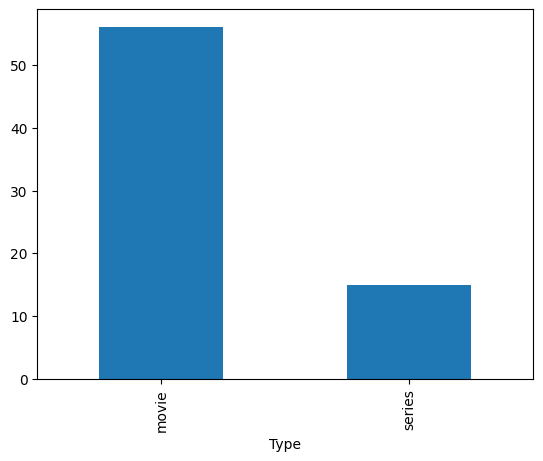

In [30]:
dados.Type.value_counts().plot(kind='bar')